# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow==2.8 tensorflow-gpu==2.8 opencv-python matplotlib  protobuf==3.19.1


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached tensorflow-2.8.0-cp310-cp310-win_amd64.whl (438.0 MB)
  Using cached tensorflow_gpu-2.8.0-cp310-cp310-win_amd64.whl (438.0 MB)
  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
  Using cached matplotlib-3.7.1-cp310-cp310-win_amd64.whl (7.6 MB)
  Using cached protobuf-3.19.1-py2.py3-none-any.whl (162 kB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached flatbuffers-23.3.3-py2.py3-none-any.whl (26 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
     ---------------------------------------- 4.1/4.1 MB 32.7 MB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached libclang-16.0.0-py2

In [ ]:
!pip list

In [78]:
import tensorflow as tf
import os

In [81]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [82]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
# 2. Remove dodgy images

In [34]:
import cv2
import imghdr

In [35]:
data_dir = 'data' 

In [36]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [37]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [40]:
import numpy as np
from matplotlib import pyplot as plt

In [41]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 304 files belonging to 2 classes.


In [42]:
data_iterator = data.as_numpy_iterator()

In [43]:
batch = data_iterator.next()

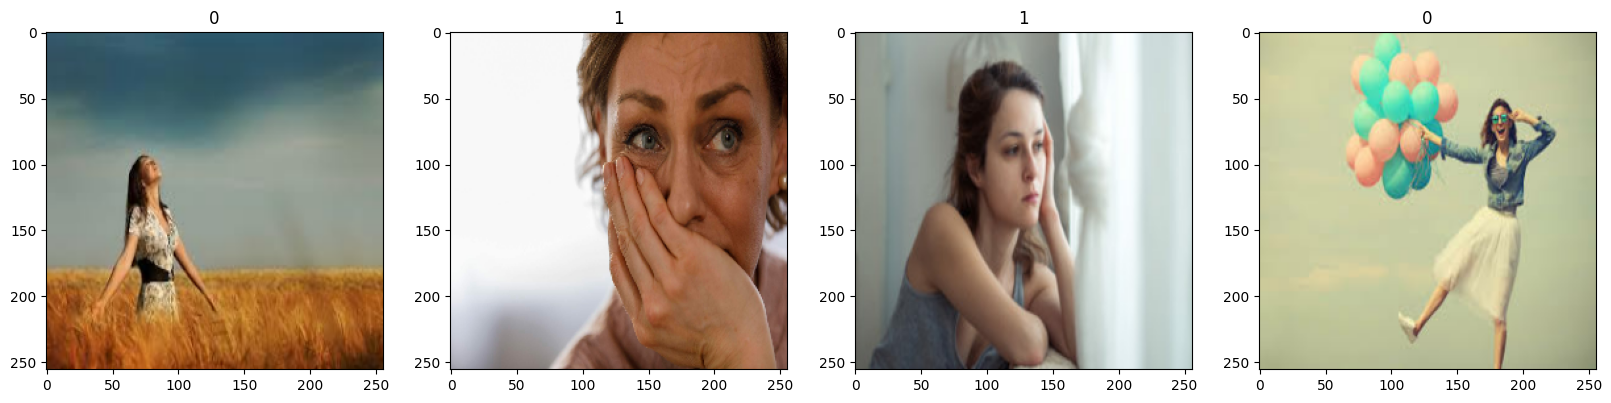

In [44]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [45]:
data = data.map(lambda x,y: (x/255, y))

In [46]:
data.as_numpy_iterator().next()

(array([[[[0.93501836, 0.93501836, 0.93501836],
          [0.93501836, 0.93501836, 0.93501836],
          [0.93501836, 0.93501836, 0.93501836],
          ...,
          [0.93333334, 0.93333334, 0.93333334],
          [0.93333334, 0.93333334, 0.93333334],
          [0.93333334, 0.93333334, 0.93333334]],
 
         [[0.93612134, 0.93612134, 0.93612134],
          [0.93612134, 0.93612134, 0.93612134],
          [0.93612134, 0.93612134, 0.93612134],
          ...,
          [0.93333334, 0.93333334, 0.93333334],
          [0.93333334, 0.93333334, 0.93333334],
          [0.93333334, 0.93333334, 0.93333334]],
 
         [[0.93391544, 0.93391544, 0.93391544],
          [0.93391544, 0.93391544, 0.93391544],
          [0.93391544, 0.93391544, 0.93391544],
          ...,
          [0.93333334, 0.93333334, 0.93333334],
          [0.93333334, 0.93333334, 0.93333334],
          [0.93333334, 0.93333334, 0.93333334]],
 
         ...,
 
         [[0.9893995 , 0.9893995 , 0.9893995 ],
          [0.98939

# 5. Split Data

In [47]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [48]:
train_size

7

In [49]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [50]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [52]:
model = Sequential()

In [53]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [54]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [56]:
logdir='logs'

In [57]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [58]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 16s 1s/step - loss: 1.0413 - accuracy: 0.5045 - val_loss: 0.7233 - val_accuracy: 0.5312
Epoch 2/20
7/7 [==============================] - 8s 1s/step - loss: 0.7000 - accuracy: 0.5179 - val_loss: 0.6922 - val_accuracy: 0.5938
Epoch 3/20
7/7 [==============================] - 10s 1s/step - loss: 0.6862 - accuracy: 0.6607 - val_loss: 0.6595 - val_accuracy: 0.6094
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 0.6451 - accuracy: 0.6295 - val_loss: 0.6391 - val_accuracy: 0.6406
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.5652 - accuracy: 0.7500 - val_loss: 0.4813 - val_accuracy: 0.7812
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 0.4999 - accuracy: 0.8170 - val_loss: 0.4592 - val_accuracy: 0.7812
Epoch 7/20
7/7 [==============================] - 12s 1s/step - loss: 0.4666 - accuracy: 0.7857 - val_loss: 0.4648 - val_accuracy: 0.7812
Epoch 8/20
7/7 [====================

# 8. Plot Performance

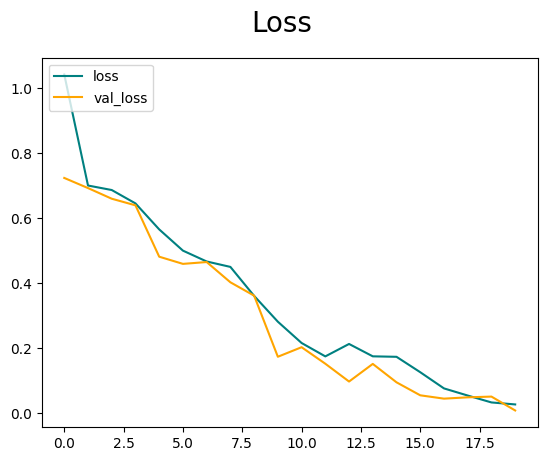

In [59]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

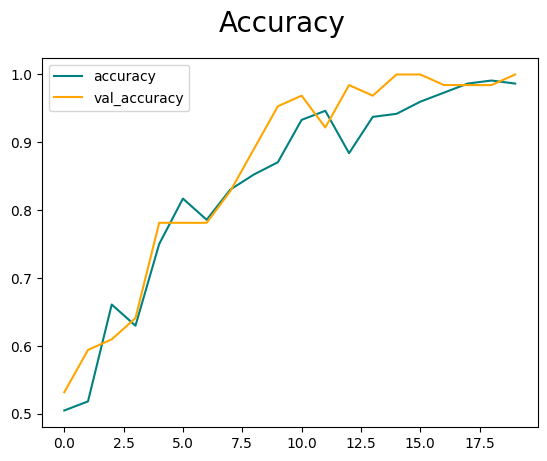

In [60]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [61]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [62]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [63]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [64]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [65]:
import cv2

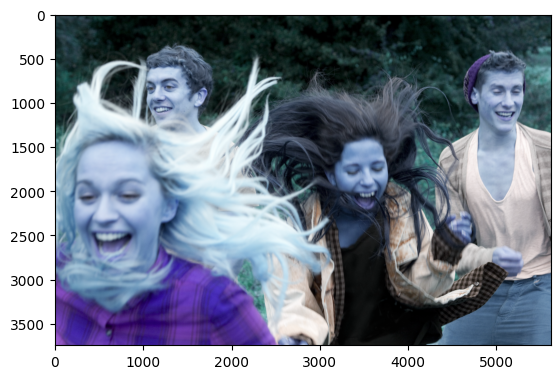

In [66]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

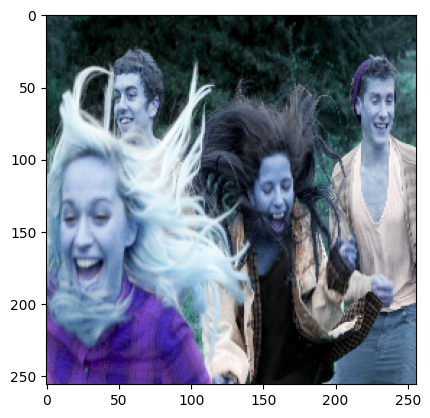

In [67]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [68]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [69]:
yhat

array([[0.14354044]], dtype=float32)

In [70]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [71]:
from tensorflow.keras.models import load_model

In [72]:
model.save(os.path.join('models','imageclassifiertestversion.h5'))

In [74]:
new_model = load_model(os.path.join('models','imageclassifiertestversion.h5'))

In [75]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.14354044]], dtype=float32)